In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import cmocean
from matplotlib import pyplot as plt

In [3]:
import os
import pathlib
import sys
from subprocess import call

In [4]:
from datetime import datetime

from dateparser import parse

In [5]:
from datetime import datetime, timedelta

In [6]:
import numpy as np
import pandas as pd
import xarray as xr

In [7]:
sys.path.append("../code/")

In [8]:
import src

### parameters for papermill 

In [9]:
domain = "Ninos"
dpath = "/media/nicolasf/END19101/data/OISST/daily"
clim_path = "/home/nicolasf/operational/OISST_indices/outputs/"
shapes_path = "/home/nicolasf/operational/OISST_indices/data/shapefiles/"
fig_path = "/home/nicolasf/operational/OISST_indices/figures/"
ndays_agg = 30
nmonths_back = 12 * 3
quantile = 0.9
lag = 0

### get the pathlib paths for the data and the climatology 

In [10]:
dpath = pathlib.Path(dpath).joinpath(domain)
clim_path = pathlib.Path(clim_path).joinpath(domain)
shapes_path = pathlib.Path(shapes_path)
fig_path = pathlib.Path(fig_path)

### get the current date 

In [11]:
current_date = datetime.utcnow()

In [12]:
first_day = parse(f"{nmonths_back} months ago")

In [13]:
first_day = first_day - timedelta(days=first_day.day - 1)

In [14]:
first_day

datetime.datetime(2019, 8, 1, 15, 27, 1, 733455)

## get the years to read 

In [15]:
years_to_get = np.unique(np.arange(1981, current_date.year + 1))
# years_to_get = np.unique(np.arange(first_day.year, current_date.year + 1))

In [16]:
lfiles = [dpath.joinpath(f"sst.day.mean.{year}.v2.nc") for year in years_to_get]

In [17]:
lfiles[0]

PosixPath('/media/nicolasf/END19101/data/OISST/daily/Ninos/sst.day.mean.1981.v2.nc')

In [18]:
lfiles[-1]

PosixPath('/media/nicolasf/END19101/data/OISST/daily/Ninos/sst.day.mean.2022.v2.nc')

## opens the near realtime dataset 

In [19]:
dset = xr.open_mfdataset(lfiles, parallel=True, combine="by_coords")

In [20]:
dset

<xarray.Dataset>
Dimensions:  (time: 14954, lon: 360, lat: 60)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-09-02 ... 2022-08-10
  * lon      (lon) float32 190.1 190.4 190.6 190.9 ... 279.1 279.4 279.6 279.9
  * lat      (lat) float32 -9.875 -9.625 -9.375 -9.125 ... 4.375 4.625 4.875
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(122, 60, 360), meta=np.ndarray>

### calculates the rolling averages here if the number of days > 1

In [21]:
if ndays_agg > 1:

    dset = dset.rolling({'time':ndays_agg}, min_periods=ndays_agg, center=False).mean('time')
    
    dset = dset.isel(time=slice(ndays_agg+1, None))

## get the first and last day from the dataset itself now

In [22]:
first_day = pd.to_datetime(dset.time.data[0])
last_day = pd.to_datetime(dset.time.data[-1])

### creates a standard calendar including leap years, the dataset will be interpolated on it at the end 

In [23]:
standard_calendar = pd.date_range(start=first_day, end=last_day, freq="D")

### get rid of the 29th of Feb if present 

In [24]:
dset = dset.convert_calendar("noleap")

In [25]:
dset = src.calculates_ninos(dset, nino='all')

### opens the climatologie(s)

In [26]:
clim_1991_2020 = xr.open_zarr(
    clim_path.joinpath(f"{domain}_OISST_{ndays_agg}days_climatology_15_window.zarr")
)

In [27]:
clim_1961_1990 = xr.open_zarr(
    clim_path.joinpath(f"{domain}_OISST_{ndays_agg}days_climatology_15_window_1961_1990.zarr")
)

### calculate the anomalies with respect to the 1991-2020 average

In [28]:
anoms_ts_1991_2020 = dset.groupby(dset.time.dt.dayofyear) - clim_1991_2020["average"]

In [29]:
anoms_ts_1961_1990 = dset.groupby(dset.time.dt.dayofyear) - clim_1961_1990["average"]

### repeat the climatology over the time dimension 

In [30]:
clim_1991_2020_repeat = clim_1991_2020.sel(dayofyear=dset.time.dt.dayofyear)
clim_1961_1990_repeat = clim_1961_1990.sel(dayofyear=dset.time.dt.dayofyear)

### Now interpolate over the standard calendar 

In [31]:
anoms_ts_1991_2020 = anoms_ts_1991_2020.interp_calendar(standard_calendar)
anoms_ts_1961_1990 = anoms_ts_1961_1990.interp_calendar(standard_calendar)

### casts to a pandas dataframe 

In [32]:
anoms_ts_1961_1990

<xarray.Dataset>
Dimensions:    (nino: 5, time: 1287)
Coordinates:
  * nino       (nino) object '1+2' '3' '4' '3.4' 'oni'
    dayofyear  (time) float64 32.0 33.0 34.0 35.0 ... 219.0 220.0 221.0 222.0
  * time       (time) datetime64[ns] 2019-02-01 2019-02-02 ... 2022-08-10
Data variables:
    sst        (nino, time) float64 dask.array<chunksize=(1, 1287), meta=np.ndarray>

In [33]:
anoms_ts_1991_2020

<xarray.Dataset>
Dimensions:    (nino: 5, time: 1287)
Coordinates:
  * nino       (nino) object '1+2' '3' '4' '3.4' 'oni'
    dayofyear  (time) float64 32.0 33.0 34.0 35.0 ... 219.0 220.0 221.0 222.0
  * time       (time) datetime64[ns] 2019-02-01 2019-02-02 ... 2022-08-10
Data variables:
    sst        (nino, time) float64 dask.array<chunksize=(1, 1287), meta=np.ndarray>

In [34]:
anoms_ts_1991_2020 = anoms_ts_1991_2020['sst'].to_pandas().T
anoms_ts_1961_1990 = anoms_ts_1961_1990['sst'].to_pandas().T

In [35]:
anoms_ts_1991_2020.head()

nino,1+2,3,4,3.4,oni
time,,,,,
2019-02-01,0.889904,0.730064,0.713735,0.673225,0.673225
2019-02-02,0.906562,0.720113,0.713020,0.662011,0.662011
2019-02-03,0.917508,0.710886,0.713912,0.652139,0.652139
2019-02-04,0.925329,0.704300,0.716035,0.645561,0.645561
2019-02-05,0.932620,0.697728,0.720800,0.641086,0.641086


<AxesSubplot:xlabel='time'>

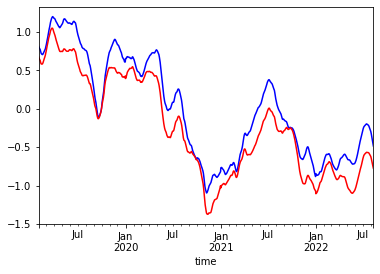

In [36]:
anoms_ts_1961_1990['oni'].plot(color='b')
anoms_ts_1991_2020['oni'].plot(color='r')

In [37]:
dset.nino.data[:-1]

array(['1+2', '3', '4', '3.4'], dtype=object)

### Plot the time-series 

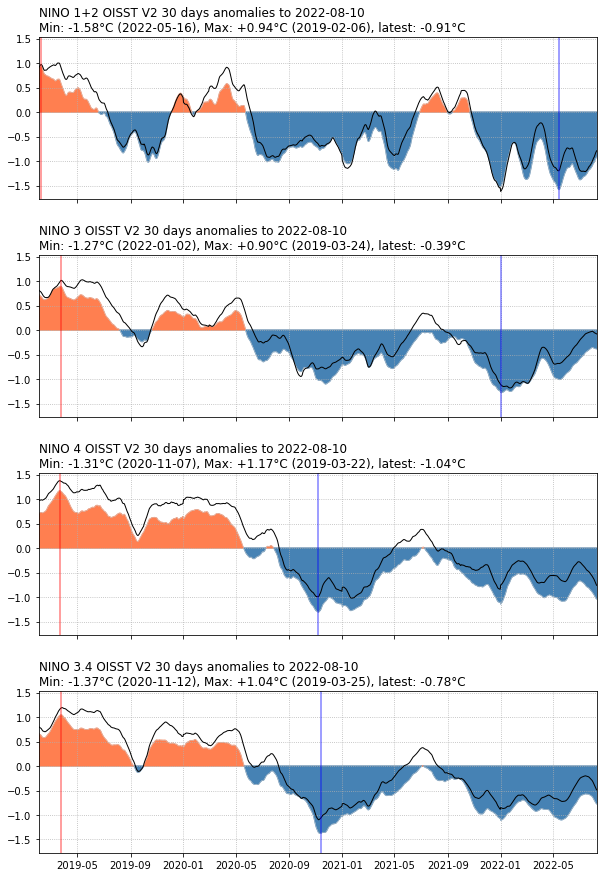

In [38]:
f, axes = plt.subplots(
    nrows=len(dset.nino.data[:-1]), figsize=(10, 15), sharex=True, sharey=True
)

plt.subplots_adjust(hspace=0.35)

for i, region in enumerate(dset.nino.data[:-1]):

    ax = axes[i]

    df = anoms_ts_1991_2020.loc[:, region]
    
    df_old = anoms_ts_1961_1990.loc[:, region]
    

    ax.fill_between(
        df.index, 0, df.values, df.values > 0, interpolate=True, color="coral"
    )
    ax.fill_between(
        df.index, 0, df.values, df.values <= 0, interpolate=True, color="steelblue"
    )

    ax.plot(df.index, df.values, color="0.8", lw=0.5)
    
    ax.plot(df_old.index, df_old.values, color="k", lw=1)

    ax.grid(ls=":")

    title = f"NINO {region} OISST V2 {ndays_agg} days anomalies to {last_day:%Y-%m-%d}\nMin: {df.min():+4.2f}°C ({df.idxmin():%Y-%m-%d}), Max: {df.max():+4.2f}°C ({df.idxmax():%Y-%m-%d}), latest: {df.iloc[-1]:+4.2f}°C"

    ax.set_title(title, loc="left")

    ax.axhline(0, color="0.8", zorder=-1)

    ax.axvline(df.idxmin(), color="b", alpha=0.5)
    ax.axvline(df.idxmax(), color="r", alpha=0.5)

    ax.set_xlim(first_day, last_day)

In [39]:
f.savefig(
    f"/home/nicolasf/Desktop/prototype_NINO_indices_{ndays_agg}days_agg_to_{last_day:%Y%m%d}.png",
    dpi=200,
    bbox_inches="tight",
    facecolor="w",
)

In [40]:
dset.close()

In [41]:
diff = (anoms_ts_1991_2020 - anoms_ts_1961_1990)

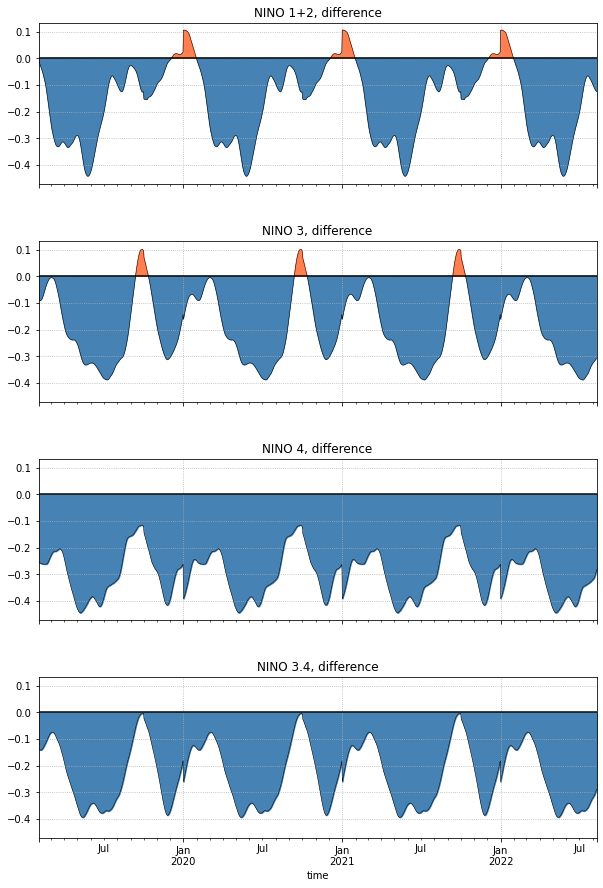

In [42]:
f, axes = plt.subplots(
    nrows=len(dset.nino.data[:-1]), figsize=(10, 15), sharex=True, sharey=True
)

plt.subplots_adjust(hspace=0.35)

for i, region in enumerate(dset.nino.data[:-1]):

    ax = axes[i]

    df = diff.loc[:, region]
    
    ax.fill_between(
        df.index, 0, df.values, df.values > 0, interpolate=True, color="coral"
    )
    ax.fill_between(
        df.index, 0, df.values, df.values <= 0, interpolate=True, color="steelblue"
    )
    
    df.plot(ax=ax, color='k', lw=0.5)
    
    ax.set_title(f"NINO {region}, difference")
    
    ax.axhline(0, color='k')
    
    ax.grid(ls=':')
    
    

In [43]:
f.savefig(
    f"/home/nicolasf/Desktop/difference_NINO_indices_{ndays_agg}days_agg_to_{last_day:%Y%m%d}.png",
    dpi=200,
    bbox_inches="tight",
    facecolor="w",
)

In [44]:
diff_seas = diff.groupby(diff.index.day_of_year).mean()

In [45]:
diff_clim = (clim_1991_2020 - clim_1961_1990)

In [46]:
diff_clim = diff_clim['average'].to_pandas().T

In [47]:
from calendar import monthrange

In [48]:
xticks = [monthrange(2022,m)[-1] for m in range(1,13)]

In [49]:
xticks

[31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

In [50]:
xticks.insert(0,0)

In [51]:
xticks = xticks[:-1]

In [52]:
len(xticks)

12

In [53]:
xticks = np.array(xticks).cumsum()

In [54]:
from calendar import month_abbr

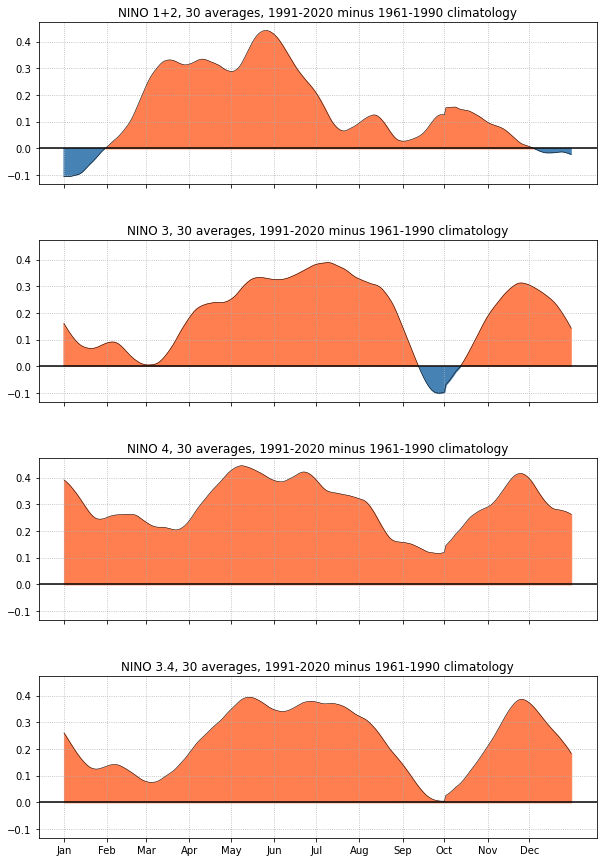

In [55]:
f, axes = plt.subplots(
    nrows=len(dset.nino.data[:-1]), figsize=(10, 15), sharex=True, sharey=True
)

plt.subplots_adjust(hspace=0.35)

for i, region in enumerate(dset.nino.data[:-1]):

    ax = axes[i]

    df = diff_clim.loc[:, region]
    
    ax.fill_between(
        np.arange(len(df)), 0, df.values, df.values > 0, interpolate=True, color="coral"
    )
    ax.fill_between(
        np.arange(len(df)), 0, df.values, df.values <= 0, interpolate=True, color="steelblue"
    )
    
    ax.plot(np.arange(len(df)), df.values, color='k', lw=0.5)
    
    # df.plot(ax=ax, color='k', lw=0.5)
    
    ax.set_title(f"NINO {region}, {ndays_agg} averages, 1991-2020 minus 1961-1990 climatology")
    
    ax.axhline(0, color='k')
    
    ax.grid(ls=':')
    
    ax.axes.xaxis.set_ticks([])
    ax.axes.xaxis.set_ticklabels([])
    
    ax.set_xticks(xticks)
    
    ax.set_xticklabels(month_abbr[1:])
    

In [56]:
f.savefig(
    f"/home/nicolasf/Desktop/difference_climos_{ndays_agg}days_agg_to_{last_day:%Y%m%d}.png",
    dpi=200,
    bbox_inches="tight",
    facecolor="w",
)